<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/2_2_Least_error_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificador por mínimo error**

Implementación de un clasificador por mínimo error por medio de la **curva ROC**.
<br><br>
Los datasets se generan con una **distribución Gaussiana** dado una media ($\mu$) y una desviación estandar ($\sigma$). Se realizarán pruebas modificando los parámetros ($\mu$ y $\sigma$).
<br><br>
La calidad de la clasificación en todos los casos se evalúa a partir de los parámetros: **precisión, exactitud y F1-score**.

## **1. Funciones y librerias**

Primero se definen funciones útiles para el desarrollo del trabajo práctico.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [ ]:
def create_dataset(mu1:float, sigma1:float, mu2:float, sigma2:float, n_samples:int):
  '''
  Creates a dataset with two target values ['A', 'B'] and attribute values with 
  Gaussian distribution for specified values of mean (mu) and standard 
  deviation (sigma).

  Output
  ------
  out1: pandas.DataFrame
        Output dataset with two columns named 'Val' and 'Etiq'. The first 
        has the feature values with a Gaussian distribution and the second 
        has the two possible target values ['A', 'B'].
  
  Inputs
  ------
  mu1: float
       Mean ("centre") of the distribution for the target 'A'.

  sigma1: float
          Standard deviation (spread or “width”) of the distribution 
          for the target 'A'. Must be non-negative.
  
  mu2: float
       Mean ("centre") of the distribution for the target 'B'.

  sigma2: float
          Standard deviation (spread or “width”) of the distribution 
          for the target 'B'. Must be non-negative.

  n_samples: int
             Total number of samples for each target value.
  '''
  # Creates a seed for random creation
  np.random.seed(1)

  # Values for target 'A'
  target_A = pd.DataFrame(np.random.normal(loc = mu1, scale = sigma1, size = (n_samples,1)),
                          columns=['Val'])
  target_A['Etiq'] = 'A'

  # Values for target 'B'
  target_B = pd.DataFrame(np.random.normal(loc = mu2, scale = sigma2, size = (n_samples,1)),
                          columns=['Val'])
  target_B['Etiq'] = 'B'

  # Join both target values in one dataframe
  dataset = pd.concat([target_A, target_B])
  dataset = dataset.reset_index(drop=True)

  return dataset


def roc_curve(dataset, show:bool=True):
  '''
  Creates a ROC curve with data in `dataset`.

  Output
  ------
  out1: list
        False positive rate (FPR). This is calculate for class 'A' in `dataset`.

  out2: list
        True positive rate (TPR). This is calculate for class 'B' in `dataset`.

  Inputs
  ------
  dataset: pandas.DataFrame
           Dataset with which the curve is calculated. It must have two 
           columns: first one with features values; second one with target 
           values.
  
  show: bool, default=True
        Whether to show or not the ROC curve.
  '''
  # Variables to execute for counting
  tpr, fpr = [], []
  TP, FP = 0, 0

  # Gets number os samples for each target value
  samples_A = dataset[dataset['Etiq'] == 'A'].shape[0]
  samples_B = dataset[dataset['Etiq'] == 'B'].shape[0]

  # Sort values by feature values
  dataset_ = dataset.copy()
  dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

  # Iterates over each row in `dataset`
  # `row` is a tuple that has the following values (index, column1, column2)
  for row in dataset_.itertuples():

    # `row[2]` takes the target value
    if row[2] == 'A':
      FP = FP + 1
    else:
      TP = TP + 1

    tpr.append(TP/samples_B)
    fpr.append(FP/samples_A)

  # Displays ROC curve if `show=True`
  if show:
    plt.plot(fpr, tpr)
    plt.title('Curva ROC')
    plt.xlabel("FPR(A)")
    plt.ylabel("TPR(B)")
    plt.show()
  
  return fpr, tpr



def get_farthest(fpr, tpr, show=True):
  '''
  Gets the farthest point of the ROC curve points from the points on a 45° line.

  Output
  ------
  out1: tuple
        Farthest ROC curve point (fpr, tpr) 


  Inputs
  ------
  fpr: list
        False positive rate (FPR).

  tpr: list
       True positive rate (TPR).

  show: bool
        Whether to show or not the ROC curve, 45° line and the farthest point.
  '''
  # Gets the pairs of points of the ROC curve
  roc_curve_points = list(zip(fpr, tpr))
  total_points = len(roc_curve_points)

  # Gets the pairs of points of the line
  points = list(np.linspace(start=0.0, stop=1.0, num=total_points))
  line_points = list(zip(points, points))

  # Calculates Euclidean distance for each pair points
  distances = []
  for index in range(total_points):
    roc_point = np.array(roc_curve_points[index])
    line_point = np.array(line_points[index])
    distance =  np.sqrt(np.sum(np.square(line_point - roc_point)))
    distances.append(distance)

  # Gets the farthest ROC curve point from line
  distances = np.array(distances)
  farthest_point = roc_curve_points[np.argmax(distances)]

  if show:
    plt.plot(fpr, tpr)
    plt.plot(points, points)
    plt.scatter(farthest_point[0], farthest_point[1], c='red')
    plt.title(f'Farthest point found at {farthest_point}')
    plt.xlabel("FPR(A)")
    plt.ylabel("TPR(B)")
    plt.show()
  
  return farthest_point


def get_threshold(dataset, farthest_point, n_samples):
  '''
  Calculates the threshold value that satisfies the count rate for the 
  farthest point on the ROC curve.

  Inputs
  ------
  dataset: pandas.DataFrame
           Dataset with which the threshold is calculated. It must have two 
           columns: first one with features values; second one with target 
           values.

  farthest_point: tuple
                  Farthest ROC curve point (fpr, tpr)

  n_samples: int
             Total number of samples for each target value: 'A' and 'B'.
  '''
  # Gets the fractional from `farthest_point`
  # -----------------------------------------
  x_point, y_point = farthest_point
  min1, min2 = 1, 1
  umbral_tp, umbral_fp = 0, 0

  # Iterates in range `n_samples*2` because we expect each target value has 
  # same number of samples and there's only two targets: 'A' and 'B'
  for i in range(n_samples*2):
    div = i/n_samples
    diff_x = np.abs(div - x_point)
    diff_y = np.abs(div - y_point)

    if diff_x < min1:
      min1 = diff_x
      umbral_fp = i
    
    if diff_y < min2:
      min2 = diff_y
      umbral_tp = i

  print("FPR = {}, es equivalente a: {}/{}".format(x_point, umbral_fp, n_samples))
  print("TPR = {}, es equivalente a: {}/{}".format(y_point, umbral_tp, n_samples))


  # Gets the value in 'Val' column that satisfies 
  # the count of `umbral_fp` and `umbral_tp`
  # ---------------------------------------------
  A_count, B_count = 0, 0
  umbral_value = 0

  # Sort values by feature values
  dataset_ = dataset.copy()
  dataset_ = dataset_.sort_values(by = 'Val', ascending=False).reset_index(drop=True)

  for row in dataset_.itertuples():
    if row[2] == 'A':
      A_count = A_count + 1
    else:
      B_count = B_count + 1

    # Checks if the count of targets 'A' and 'B' matches the 
    # thresholds for fp and tp
    if A_count == umbral_fp and B_count == umbral_tp:

      # If so, gets the value in firts column ('Val') from `dataset` 
      # and stops the for loop
      umbral_value = row[1]
      break

  print("\nPara A = {} y B = {}, el valor es {}".format(A_count, B_count, umbral_value))

  return umbral_value



def predict(X, threshold):
  '''
  Predicts the target value from the X value, based on a threshold.

  Output
  ------
  out1: list of string
        Target value for each `X` value.

  Input
  -----
  X: numpy.ndarray of floats
     Values to predict the target.
    
  threshold: float
             Value on which the classification is based.
  '''
  y_pred = []
  for value in X:
    if value > threshold:
      y_pred.append('B')
    else:
      y_pred.append('A')

  return np.array(y_pred)



def evaluate(y_actual, y_pred, show=True):
  '''
  Evaluates the results of a model with the following metrics:
      
      - precision
      - recall
      - f1-score
      - accuracy

  Output
  ------
  out1: dict(str, dict/float)
        Summary of the precision, recall, F1 score for each class.

  out2: numpy.array
        Confusion matrix whose i-th row and j-th column entry indicates 
        the number of samples with true label being i-th class and 
        predicted label being j-th class.
  
  Inputs
  ------
  y_actual: numpy.array
            True values.
  
  y_pred: numpy.array
          Predicted values.
  
  show: bool, default=True
        Whether to show or not the confusion matrix.
  '''
  # Gets and displays the report
  report = classification_report(y_actual, y_pred, output_dict=True)
  print(classification_report(y_actual, y_pred))
  accuracy = report['accuracy']
  
  # Calculates the confusion matrix and shows it
  confusion_matrix = pd.crosstab(y_actual, y_pred, rownames=['True labels'], colnames=['Predicted labels'])
  if show:
    sns.heatmap(confusion_matrix, annot=True, cbar=False)
    plt.title(f'Matriz de confusión - Accuracy: {accuracy}')
    plt.show()
  
  return report, confusion_matrix

## **2. Dataset #1**

Se genera un dataset con dos clases (A y B), cada una con diferente media ($\mu$), desviación estándar ($\sigma$) y un total de 50 datos.



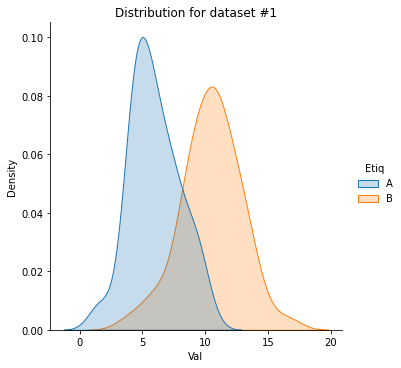

In [ ]:
dataset1 = create_dataset(mu1=6.0, sigma1=2.0, 
                          mu2=10.0, sigma2=3.0, 
                          n_samples=50)

sns.displot(data=dataset1, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title('Distribution for dataset #1')
plt.show()

Se unen los dos dataset en un solo dataframe y se grafica su distribución


### **2.1. Curva ROC**

Gráfica de la curva ROC. Se asumen como etiqueta TruePositive(TP) los valores **'B'** y FalsePositive(FP) los **'A'**


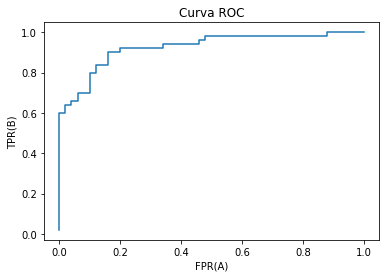

In [ ]:
fpr, tpr = roc_curve(dataset1)

### **2.2. Punto más alejado**

Se traza una línea de un sistema aleatorio y se calcula el punto más alejado de la misma.

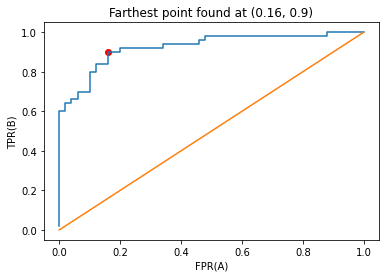

In [ ]:
farthest_point1 = get_farthest(fpr, tpr)

### **2.3. Umbral de decisión**

Se busca el valor en la columna "*Val*" del dataset la cual cumple las proporciones encontradas en el punto más lejano en la curva ROC.

In [ ]:
# `n_samples` refers to the total number of samples for each target 
# value ('A' and 'B')
threshold1 = get_threshold(dataset1, farthest_point1, n_samples=50)

FPR = 0.16, es equivalente a: 8/50
TPR = 0.9, es equivalente a: 45/50

Para A = 8 y B = 45, el valor es 7.9880131411329085


### **2.4. Clasificación**

Respecto al umbral encontrado en `threshold`, nos indica que valores ('Val') superiores a él se clasifican como la clase 'B' (`Etiq' = 'B'`), caso contrario se clasifican como 'A' (`Etiq' = 'A'`) <br><br>

$$Etiq = \left\{\begin{matrix}
 A,& Val \leq threshold \\
 B,& Val > threshold \\
\end{matrix}\right.$$


In [ ]:
X = dataset1['Val'].to_numpy()
y_pred = predict(X, threshold1)

### **2.5. Evaluación**

Se evalua el comportamiento del clasificador mediante los siguientes parámetros de calidad:

<br>

$$Exactitud = \frac{TP+ TN}{TP + TN + FP + FN}$$

<br>

$$Precision = \frac{TP}{TP + FP}$$

<br>

$$Recall = \frac{TP}{TP + FN}$$

<br>

$$F1\text{-}Score = \frac{2(Precision)(Recall)}{Precision + Recall}$$

              precision    recall  f1-score   support

           A       0.88      0.84      0.86        50
           B       0.85      0.88      0.86        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



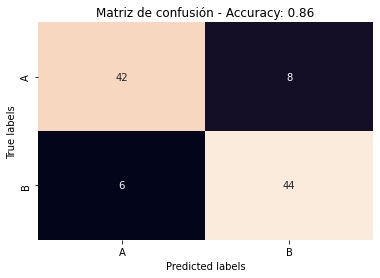

In [ ]:
y_actual = dataset1['Etiq'].to_numpy()
summary1, cm1 = evaluate(y_actual, y_pred)

Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud 86%**

## **3. Dataset #2**

Ahora se modifican las medias ($\mu$) de los dos grupos de datos para que estas se encuentren más cerca, manteniendo la misma desviación estandar ($\sigma$)

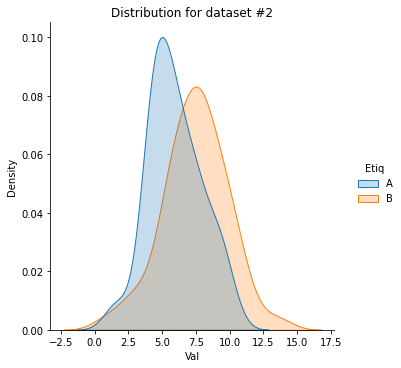

In [ ]:
dataset2 = create_dataset(mu1=6.0, sigma1=2.0, 
                          mu2=7.0, sigma2=3.0, 
                          n_samples=50)

sns.displot(data=dataset2, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title('Distribution for dataset #2')
plt.show()

### **3.1. Clasificador**

Se construye el clasificador para el dataset #2.

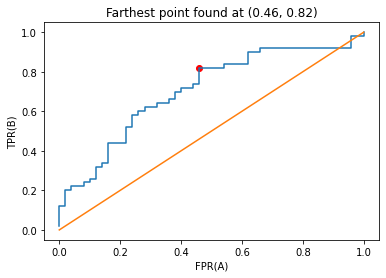



FPR = 0.46, es equivalente a: 23/50
TPR = 0.82, es equivalente a: 41/50

Para A = 23 y B = 41, el valor es 5.8741451497296575


              precision    recall  f1-score   support

           A       0.73      0.54      0.62        50
           B       0.63      0.80      0.71        50

    accuracy                           0.67       100
   macro avg       0.68      0.67      0.66       100
weighted avg       0.68      0.67      0.66       100



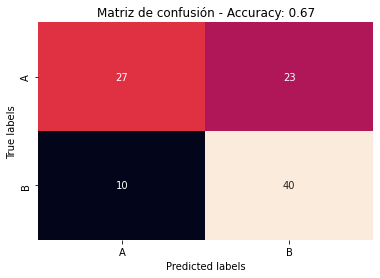

In [ ]:
# ROC Curve
fpr, tpr = roc_curve(dataset2, show=False)

# Gets the farthest point
farthest_point2 = get_farthest(fpr, tpr)

# Decision value
print('\n')
threshold2 = get_threshold(dataset2, farthest_point2, n_samples=50)

# Predict target values
X = dataset2['Val'].to_numpy()
y_pred = predict(X, threshold2)
print('\n')

# Metrics
y_actual = dataset2['Etiq'].to_numpy()
summary2, cm2 = evaluate(y_actual, y_pred)

Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud 67%**

## **4. Dataset #3**

Se mantiene la misma media ($\mu$) del dataset #1 y ahora se disminuye la desviación estandar ($\sigma$) para los grupos A y B.

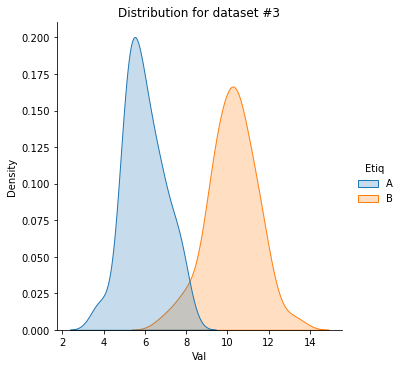

In [ ]:
dataset3 = create_dataset(mu1=6.0, sigma1=1.0, 
                          mu2=10.0, sigma2=1.5, 
                          n_samples=50)

sns.displot(data=dataset3, x='Val', hue='Etiq', kind='kde', fill=True)
plt.title('Distribution for dataset #3')
plt.show()

### **4.1. Clasificador**

Se construye el clasificador para el dataset #3.

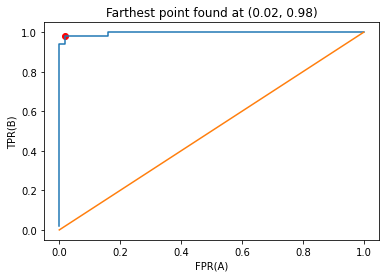



FPR = 0.02, es equivalente a: 1/50
TPR = 0.98, es equivalente a: 49/50

Para A = 1 y B = 49, el valor es 7.833829291855616


              precision    recall  f1-score   support

           A       0.96      0.98      0.97        50
           B       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



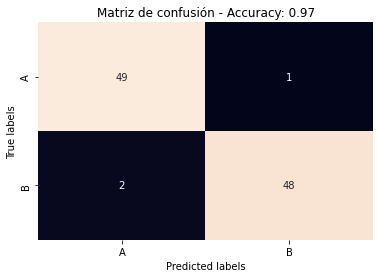

In [ ]:
# ROC Curve
fpr, tpr = roc_curve(dataset3, show=False)

# Gets the farthest point
farthest_point3 = get_farthest(fpr, tpr)

# Decision value
print('\n')
threshold3 = get_threshold(dataset3, farthest_point3, n_samples=50)

# Predict target values
X = dataset3['Val'].to_numpy()
y_pred = predict(X, threshold3)
print('\n')

# Metrics
y_actual = dataset3['Etiq'].to_numpy()
summary3, cm3 = evaluate(y_actual, y_pred)

Dados los parámetros mostrados al generar los datos, el clasificador arroja una **exactitud 97%**

# **Resumen y conclusión**

A continuación, se presentan las distribuciones de los tres datasets vistos y los resultados del clasificador implementado.

Adicional, el punto de desicion se ilustra con una linea roja punteada.

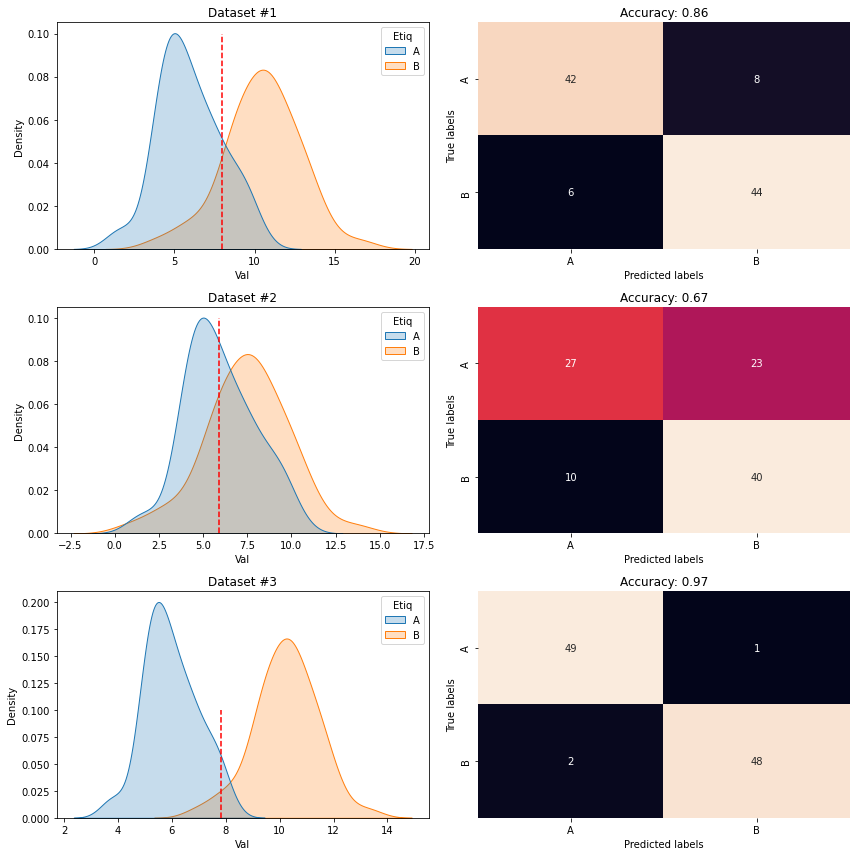

In [ ]:
# Values for vertical line in `kdeplot`
y_line = np.linspace(start=0.0, stop=0.1, num=100)

# Grid of 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(12,12))

# Dataset No. 1
x_line = np.array([threshold1]*100)
axs[0, 0].plot(x_line, y_line, c='red', linestyle='--')
sns.kdeplot(data=dataset1, x='Val', hue='Etiq', fill=True, ax=axs[0, 0])
axs[0, 0].set_title("Dataset #1")

sns.heatmap(cm1, annot=True, cbar=False, ax=axs[0, 1])
accuracy = summary1['accuracy']
axs[0, 1].set_title(f'Accuracy: {accuracy}')


# Dataset No. 2
x_line = np.array([threshold2]*100)
axs[1, 0].plot(x_line, y_line, c='red', linestyle='--')
sns.kdeplot(data=dataset2, x='Val', hue='Etiq', fill=True, ax=axs[1, 0])
axs[1, 0].set_title("Dataset #2")

sns.heatmap(cm2, annot=True, cbar=False, ax=axs[1, 1])
accuracy = summary2['accuracy']
axs[1, 1].set_title(f'Accuracy: {accuracy}')


# Dataset No. 3
x_line = np.array([threshold3]*100)
axs[2, 0].plot(x_line, y_line, c='red', linestyle='--')
sns.kdeplot(data=dataset3, x='Val', hue='Etiq', fill=True, ax=axs[2, 0])
axs[2, 0].set_title("Dataset #3")

sns.heatmap(cm3, annot=True, cbar=False, ax=axs[2, 1])
accuracy = summary3['accuracy']
axs[2, 1].set_title(f'Accuracy: {accuracy}')


plt.tight_layout()
plt.show()

* Como se observa, entre más distantes se encuentres distribuidos los datos, el clasificador presenta un mejor resultado por este método. Esto se debe a que entre menos solapadas las distribuciones, la curva ROC se aleja de la recta aleatoria y por ende es menos complejo clasificar entre las etiquetas A y B. 

* En este caso, el clasificador se escogió de manera que exista el mínimo error tanto para la tasa de falsos positivos como de verdaderos positivos. Sin embargo, dependiendo de la aplicación y contexto, el umbral se puede extraer de diferentes maneras para atender a una mayor precisión o recall.